In [1]:
import torch
import numpy as np
from datasets import load_dataset, Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm

In [2]:
# Load WER and CER metrics
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [4]:
def evaluate_model(model, processor, dataset, device="cuda"):
    """Evaluate a model on a dataset and return metrics"""
    model.to(device)
    model.eval()
    
    all_references = []
    all_predictions = []
    all_audio_names = []
    inference_times = []
    
    for sample in tqdm(dataset, desc="Evaluating"):
        # Get audio input
        audio = sample["path"]
        reference = sample["text"]
        
        # Get audio file name for analysis
        if isinstance(audio, dict) and "path" in audio:
            audio_name = os.path.basename(audio["path"])
        else:
            audio_name = "unknown"
        
        # Process audio
        input_features = processor(
            audio["array"], 
            sampling_rate=audio["sampling_rate"],
            return_tensors="pt"
        ).input_values.to(device)
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            logits = model(input_features).logits
        end_time = time.time()
        inference_time = end_time - start_time
        
        # Decode prediction
        predicted_ids = torch.argmax(logits, dim=-1)
        predicted_transcript = processor.batch_decode(predicted_ids)[0]
        
        # Store results
        all_references.append(reference)
        all_predictions.append(predicted_transcript)
        all_audio_names.append(audio_name)
        inference_times.append(inference_time)
    
    # Calculate metrics
    wer = 100 * wer_metric.compute(predictions=all_predictions, references=all_references)
    cer = 100 * cer_metric.compute(predictions=all_predictions, references=all_references)
    
    avg_inference_time = sum(inference_times) / len(inference_times)
    
    # Create detailed results for error analysis
    detailed_results = []
    for ref, pred, name, inf_time in zip(all_references, all_predictions, all_audio_names, inference_times):
        sample_wer = 100 * wer_metric.compute(predictions=[pred], references=[ref])
        detailed_results.append({
            "audio_file": name,
            "reference": ref,
            "prediction": pred,
            "wer": sample_wer,
            "inference_time": inf_time
        })
    
    results = {
        "wer": wer,
        "cer": cer,
        "avg_inference_time": avg_inference_time,
        "detailed_results": detailed_results
    }
    
    return results

In [5]:
# Load the test dataset
data_dir = os.path.abspath(os.path.join("..", "data", "processed"))
test_dataset = load_dataset("csv", data_files=os.path.join(data_dir, "test_data.csv"))["train"]

In [6]:
print(test_dataset)

Dataset({
    features: ['text', 'path'],
    num_rows: 10
})


In [7]:
 # Function to correct the file paths
def correct_path(example):
    current_path = example["path"].replace("\\", "/")
    if "../processed" in current_path:
        new_path = current_path.replace("../processed", "../data/processed")
    else:
        new_path = current_path
    example["path"] = new_path
    return example

In [8]:
 # Apply the path correction
test_dataset = test_dataset.map(correct_path)

# Cast to Audio
test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

In [9]:
# Load models and processors
base_model_name = "facebook/wav2vec2-base-960h"
base_processor = Wav2Vec2Processor.from_pretrained(base_model_name)
base_model = Wav2Vec2ForCTC.from_pretrained(base_model_name)

# Load fine-tuned model
finetuned_model_dir = "../output/models/wav2vec2/best_model"
finetuned_processor = Wav2Vec2Processor.from_pretrained(finetuned_model_dir)
finetuned_model = Wav2Vec2ForCTC.from_pretrained(finetuned_model_dir)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

e:\Singaporean_English_ASR\.venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mh\.cache\huggingface\hub\models--facebook--wav2vec2-base-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluate both models
print("Evaluating base model...")
base_results = evaluate_model(base_model, base_processor, test_dataset, device)

print("Evaluating fine-tuned model...")
finetuned_results = evaluate_model(finetuned_model, finetuned_processor, test_dataset, device)


Using device: cuda
Evaluating base model...


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Evaluating fine-tuned model...


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 30.05it/s]


In [11]:
# Print overall results
print("\n===== EVALUATION RESULTS =====")
print(f"Base Wav2Vec2 WER: {base_results['wer']:.2f}%")
print(f"Fine-tuned Wav2Vec2 WER: {finetuned_results['wer']:.2f}%")
print(f"WER improvement: {base_results['wer'] - finetuned_results['wer']:.2f}%")

print(f"\nBase Wav2Vec2 CER: {base_results['cer']:.2f}%")
print(f"Fine-tuned Wav2Vec2 CER: {finetuned_results['cer']:.2f}%")
print(f"CER improvement: {base_results['cer'] - finetuned_results['cer']:.2f}%")

print(f"\nBase model avg inference time: {base_results['avg_inference_time']:.4f}s")
print(f"Fine-tuned model avg inference time: {finetuned_results['avg_inference_time']:.4f}s")


===== EVALUATION RESULTS =====
Base Wav2Vec2 WER: 105.26%
Fine-tuned Wav2Vec2 WER: 100.00%
WER improvement: 5.26%

Base Wav2Vec2 CER: 87.19%
Fine-tuned Wav2Vec2 CER: 216.67%
CER improvement: -129.48%

Base model avg inference time: 0.1142s
Fine-tuned model avg inference time: 0.0105s


In [12]:
# Create comparison of individual file performance
base_wers = [item["wer"] for item in base_results["detailed_results"]]
finetuned_wers = [item["wer"] for item in finetuned_results["detailed_results"]]
audio_files = [item["audio_file"] for item in base_results["detailed_results"]]


In [13]:
# Create and save a comparison table
comparison_df = pd.DataFrame({
    "Audio File": audio_files,
    "Base WER": base_wers,
    "Fine-tuned WER": finetuned_wers,
    "WER Improvement": [b - f for b, f in zip(base_wers, finetuned_wers)],
    "Base Reference": [item["reference"] for item in base_results["detailed_results"]],
    "Base Prediction": [item["prediction"] for item in base_results["detailed_results"]],
    "Fine-tuned Prediction": [item["prediction"] for item in finetuned_results["detailed_results"]]
})

In [14]:
# Save to CSV
os.makedirs("../output/evaluations/wav2vec2", exist_ok=True)
comparison_df.to_csv("../output/evaluations/wav2vec2/wav2vec2_comparison.csv", index=False)
print(f"Detailed comparison saved to ../output/evaluations/wav2vec2/wav2vec2_comparison.csv")

Detailed comparison saved to ../output/evaluations/wav2vec2/wav2vec2_comparison.csv


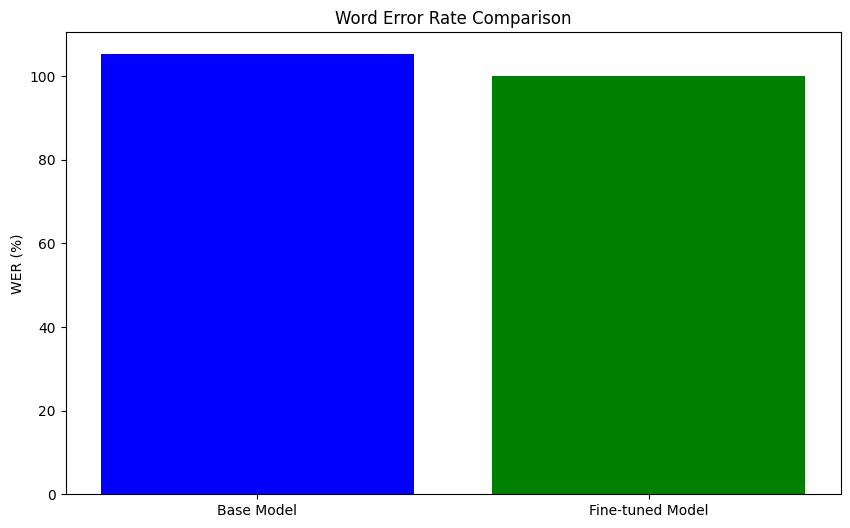

In [15]:
 # Create visualizations
plt.figure(figsize=(10, 6))
plt.bar(['Base Model', 'Fine-tuned Model'], [base_results['wer'], finetuned_results['wer']], color=['blue', 'green'])
plt.title('Word Error Rate Comparison')
plt.ylabel('WER (%)')
plt.savefig("../output/evaluations/wav2vec2/wer_comparison.png")

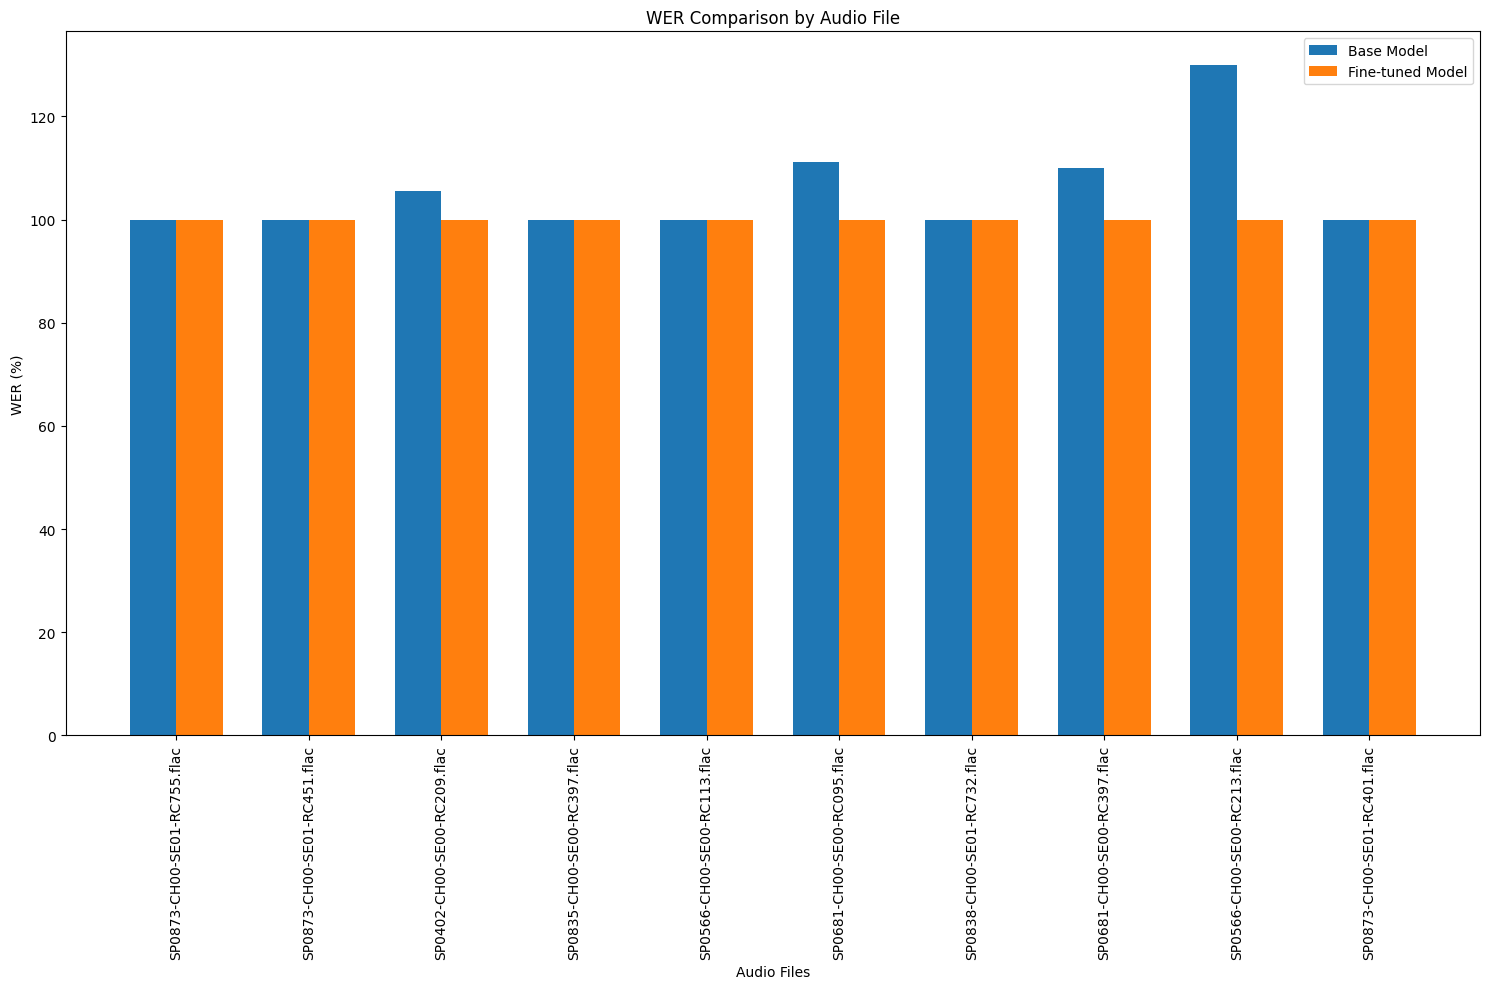

In [16]:
# Compare individual audio file performance
plt.figure(figsize=(15, 10))
indices = range(len(audio_files))
width = 0.35
plt.bar(indices, base_wers, width, label='Base Model')
plt.bar([i + width for i in indices], finetuned_wers, width, label='Fine-tuned Model')
plt.xlabel('Audio Files')
plt.ylabel('WER (%)')
plt.title('WER Comparison by Audio File')
plt.xticks([i + width/2 for i in indices], audio_files, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../output/evaluations/wav2vec2/wer_by_file.png")

In [17]:
# Error analysis for failed cases
# Find examples where fine-tuned model performed worse
worse_cases = comparison_df[comparison_df["WER Improvement"] < 0].sort_values("WER Improvement")

if len(worse_cases) > 0:
    print("\n===== CASES WHERE FINE-TUNED MODEL PERFORMED WORSE =====")
    for _, row in worse_cases.head(5).iterrows():
        print(f"\nAudio: {row['Audio File']}")
        print(f"Reference: {row['Base Reference']}")
        print(f"Base model: {row['Base Prediction']} (WER: {row['Base WER']:.2f}%)")
        print(f"Fine-tuned: {row['Fine-tuned Prediction']} (WER: {row['Fine-tuned WER']:.2f}%)")
        print(f"WER change: {row['WER Improvement']:.2f}%")
    

In [18]:
# Find examples where fine-tuned model performed much better
better_cases = comparison_df[comparison_df["WER Improvement"] > 0].sort_values("WER Improvement", ascending=False)

if len(better_cases) > 0:
    print("\n===== CASES WHERE FINE-TUNED MODEL PERFORMED BETTER =====")
    for _, row in better_cases.head(5).iterrows():
        print(f"\nAudio: {row['Audio File']}")
        print(f"Reference: {row['Base Reference']}")
        print(f"Base model: {row['Base Prediction']} (WER: {row['Base WER']:.2f}%)")
        print(f"Fine-tuned: {row['Fine-tuned Prediction']} (WER: {row['Fine-tuned WER']:.2f}%)")
        print(f"WER change: {row['WER Improvement']:.2f}%")


===== CASES WHERE FINE-TUNED MODEL PERFORMED BETTER =====

Audio: SP0566-CH00-SE00-RC213.flac
Reference: set a stop-loss order of 50% for my current order.
Base model: SET A STOP LOST ORDER OF FIFTY PER CENT FOR MY CURREN ORDER (WER: 130.00%)
Fine-tuned: zyzyzyzyzyzyzvy’ywryzszyvwyhkyzyzyz[UNK]zyk’kyzzyzyfyzyzyt[UNK]z[UNK]yzy’zzwnzyzyzyzyzyzkyzy’zyzyz’xyzzyz (WER: 100.00%)
WER change: 30.00%

Audio: SP0681-CH00-SE00-RC095.flac
Reference: most youths today think that their future is uncertain.
Base model: MOST USED TO THEY THINK THAT THEIR FUTURE IS UNCERTAIN (WER: 111.11%)
Fine-tuned: kzkzkzkzvzkvkzvkzk[UNK]vwzwkzkhkvw[UNK]yktfkzkkkvkztz[UNK]kzfzkzkzkz[UNK]kzkzkzkk’l[UNK]zkz5kgwz[UNK]kzkzkzkvokqkvkv (WER: 100.00%)
WER change: 11.11%

Audio: SP0681-CH00-SE00-RC397.flac
Reference: it will improve your experience the more it knows you.
Base model: IT WAY ALL IMPROVE YOUR EXPERIENCE THE MORE IT NOWS YOU (WER: 110.00%)
Fine-tuned: zkwgkgkgzkgk[UNK]kvkvk5z5kzkzltz[UNK]yk[UNK]kxkzy[UNK]z[UNK